In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit 
from sympy import sympify, singularities, im, FiniteSet, exp, log, I, pi, zoo, Symbol, Float, N
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function 
from gplearn.fitness import make_fitness
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import make_scorer, mean_absolute_error
import nbimporter
from Visualization_functions import visualize_set, visualize_estimator, visualize_models, linear_regression, r_squared_function, get_MAE_r_squared_slope_of_est
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# Loads all the necessary data files and store the necessary data in well named variables.
Energies_train = pd.read_csv('Fe_Octhedral_complexes_rel_m_splitting.csv')
Energies_test = pd.read_csv('real_world_energies_and_relative_metal_radius.csv')
Energies_total = pd.concat([Energies_train,  Energies_test], ignore_index=True, axis=0)
df_exp = pd.read_csv("Exp_custom_spike_cst_210_models.txt")
df_add = pd.read_csv("Add_MAE_210_models.txt")

multiplicities_train = Energies_train['multiplicity']
multiplicities_test = Energies_test['multiplicity']

X_train = Energies_train[['rel_m']]
X_test = Energies_test[['rel_m']]
X = Energies_total[['rel_m']]

y_train = Energies_train['splitting']
y_test = Energies_test['splitting']
y = Energies_total['splitting']

# Sorts the lists X_test and y_test so that it is sorted for X_test but y_test has the same ordre. It is useful for the hanfling of the visualize_set function and to obtain the spin estimation percentage.
sorted_indices = np.argsort(X_test['rel_m'].values)

# Apply the sorting to X_test
X_test_list_sorted = X_test['rel_m'].values[sorted_indices]
# Apply the sorting to y_test
y_test_sorted = y_test.values[sorted_indices]

# We can here visualize the relationship that was tried to be fitted by symbolic regression in this project.

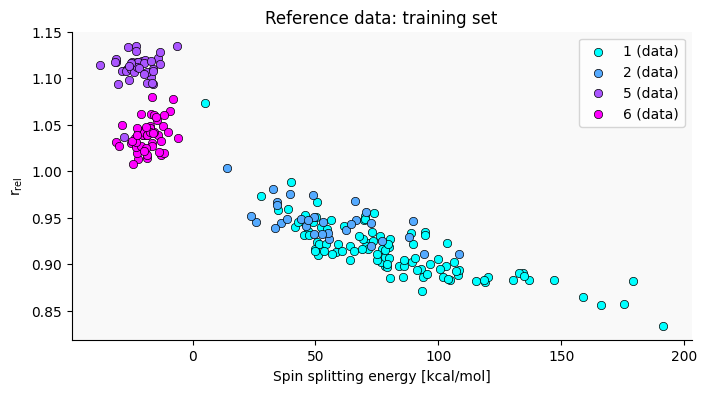

In [3]:
fig, ax = plt.subplots(figsize=(8, 4))  
visualize_set(X_train, ax)

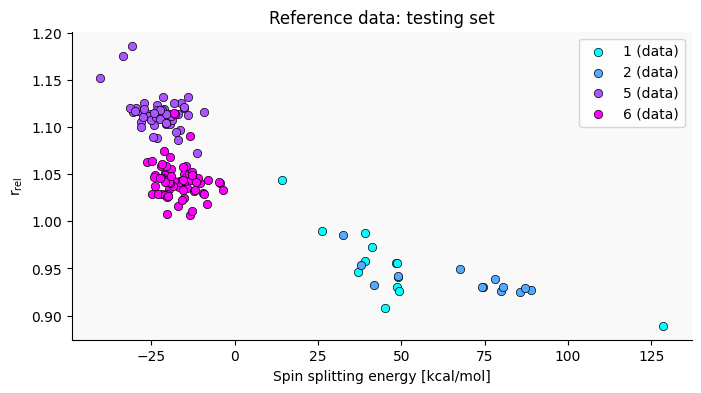

In [4]:
fig, ax = plt.subplots(figsize=(8, 4)) 
visualize_set(X_test, ax)

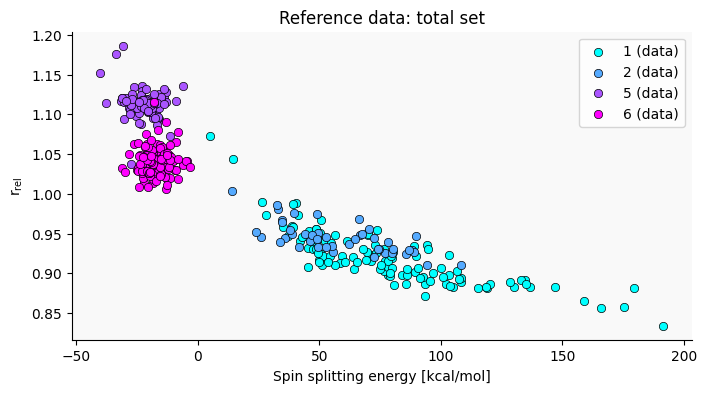

In [5]:
fig, ax = plt.subplots(figsize=(8, 4)) 
visualize_set(X, ax)

In [6]:
def find_best_program(estimator):
    # Loops through all the estimators obtained during the evolution and looks for the estimator with the lowest raw_fitness. In hindsight, this may have caused the expressions to be more daring; only the MAE is considered not if the had a singularity.
    # This may have thus made a bigger proportion of models have a singularity. 
    
    min_raw_fitness = 10000000
    for generation_idx, generation in enumerate(estimator._programs):
        for program_idx, program in enumerate(generation):
            if program:
                if program.raw_fitness_ < min_raw_fitness:
                    min_raw_fitness = program.raw_fitness_
                    i = generation_idx
                    j = program_idx
    
    best_program = estimator._programs[i][j]
    
    return best_program

def percentage_same_sign(list1, list2):    
    # Takes in the list of predicted spin-splitting energies by symbolic regression and the ones computed using DFT. If they share the same sign (the product of the two is positive) they are considered to have the same ground state spin. 
    # It yields back the percentage of well predicted ground state spin.
    
    same_sign_count = sum(
        (a * b) > 0 for a, b in zip(list1, list2)
    )
    return 100 * same_sign_count / len(list1)

# The custom fitness functions are defined. 
## The custom fitness functions are built in two steps: first, functions are defined to detect specific behaviors; then, these functions are incorporated into metrics that penalize the presence of those behaviors.

In [7]:
def is_constant(y_predicted, rtol=10, atol=1e-3):
    # This function detects if the expression obtained is seemingly constant. 
    
    y_predicted = np.asarray(y_predicted)
    
    # Require at least 3 points to compute second derivative-style behavior
    if len(y_predicted) < 3:
        return False  # treat short arrays as "constant-like"
    
    x = np.arange(len(y_predicted))  # fake x-values if none are known
    dy_dx = np.gradient(y_predicted, x)
    return np.allclose(dy_dx, dy_dx[0], ) or np.ptp(y_predicted) < rtol  


def has_spike(y_predicted, threshold=100):
    # This function detects if 2 data points that follow each other along the r_rel axis have a difference bigger than 100.

    if len(y_predicted) < 3:
        return False  # treat short arrays as "constant-like"
    
    dy = np.abs(np.diff(y_predicted))
    return np.any(dy > threshold)


def custom_fitness_spike(y, y_pred, w):

    spike_match = has_spike(y_pred)

    if spike_match:    # High fitness to penalize spike behavior
        return 1e4
    
    return np.average(np.abs(y - y_pred), weights=w)  


def custom_fitness_spike_cst(y, y_pred, w):

    constant_match = is_constant(y_pred)
    spike_match = has_spike(y_pred)

    if constant_match:   # High fitness to penalize constant behavior
        return  1e4  
    if spike_match:
        return 1e4
    
    return np.average(np.abs(y - y_pred), weights=w)  


# Creates the fitness functions.
custom_fitness_spike_wrapped = make_fitness(function=custom_fitness_spike, greater_is_better=False)
custom_fitness_spike_cst_wrapped = make_fitness(function=custom_fitness_spike_cst, greater_is_better=False)

# The custom operators and the function sets are defined.

In [8]:
# Define 'safe' log and exp functions (to avoid problems with negative numbers)
def safe_log(x):
    return np.log(np.abs(x) + 1e-5)

def safe_exp(x):
    return np.exp(np.clip(x, -10, 10))  # Clip to prevent overflow

# Define 'safe' root 3 and pow 3 functions (to avoid problems with 0 as an input--)
def safe_root_3(x):
    return np.sign(x) * (np.abs(x) + 1e-5)**(1/3)

def safe_pow_3(x):
    return np.sign(x) * (np.abs(x) + 1e-5)**(3)

# Wrap them using gplearn's make_function
log_func = make_function(function=safe_log, name='log', arity=1)
exp_func = make_function(function=safe_exp, name='exp', arity=1)
 
root_3_func = make_function(function=safe_root_3, name='root3', arity=1)
pow_3_func = make_function(function=safe_pow_3, name='pow3', arity=1)


# include standard functions to use the Symbolic Regressor
function_set_add = ['add', 'sub', 'mul', 'div']

# include standard functions to use the Symbolic Regressor
function_set_root3 = ['add', 'sub', 'mul', 'div', root_3_func, pow_3_func]

# include standard functions to use the Symbolic Regressor
function_set_exp = ['add', 'sub', 'mul', 'div', log_func, exp_func]


# Define the lists it will iterate over (function sets and fitness scores).
function_sets = [function_set_add, function_set_root3, function_set_exp]

# For printing purposes in the .txt file.
fitness_functions_dict = {'mean absolute error':'mean absolute error',
"custom fitness function to penalize functions with big spikes":custom_fitness_spike_wrapped,
"custom fitness function to penalize functions with big spikes and constant functions":custom_fitness_spike_cst_wrapped}


# Defines the symbol with which the expressions evolve.
X0 = Symbol("X0")

# Describes the alphabet to translate from the gplearn string to a readable expression.
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow3': lambda x : x**3,
    'root3': lambda x : x**(1/3)
            }


### The grid search is done for "Add" MAE, "Exp" spike, "Exp" spike/cst and the output is the MAE average MAE of the 5 best sets of parameters.

Trying: {'tournament_size': 15, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.025, 'p_crossover': 0.8, 'max_samples': 1.0, 'init_depth': (4, 10)}
random state=2


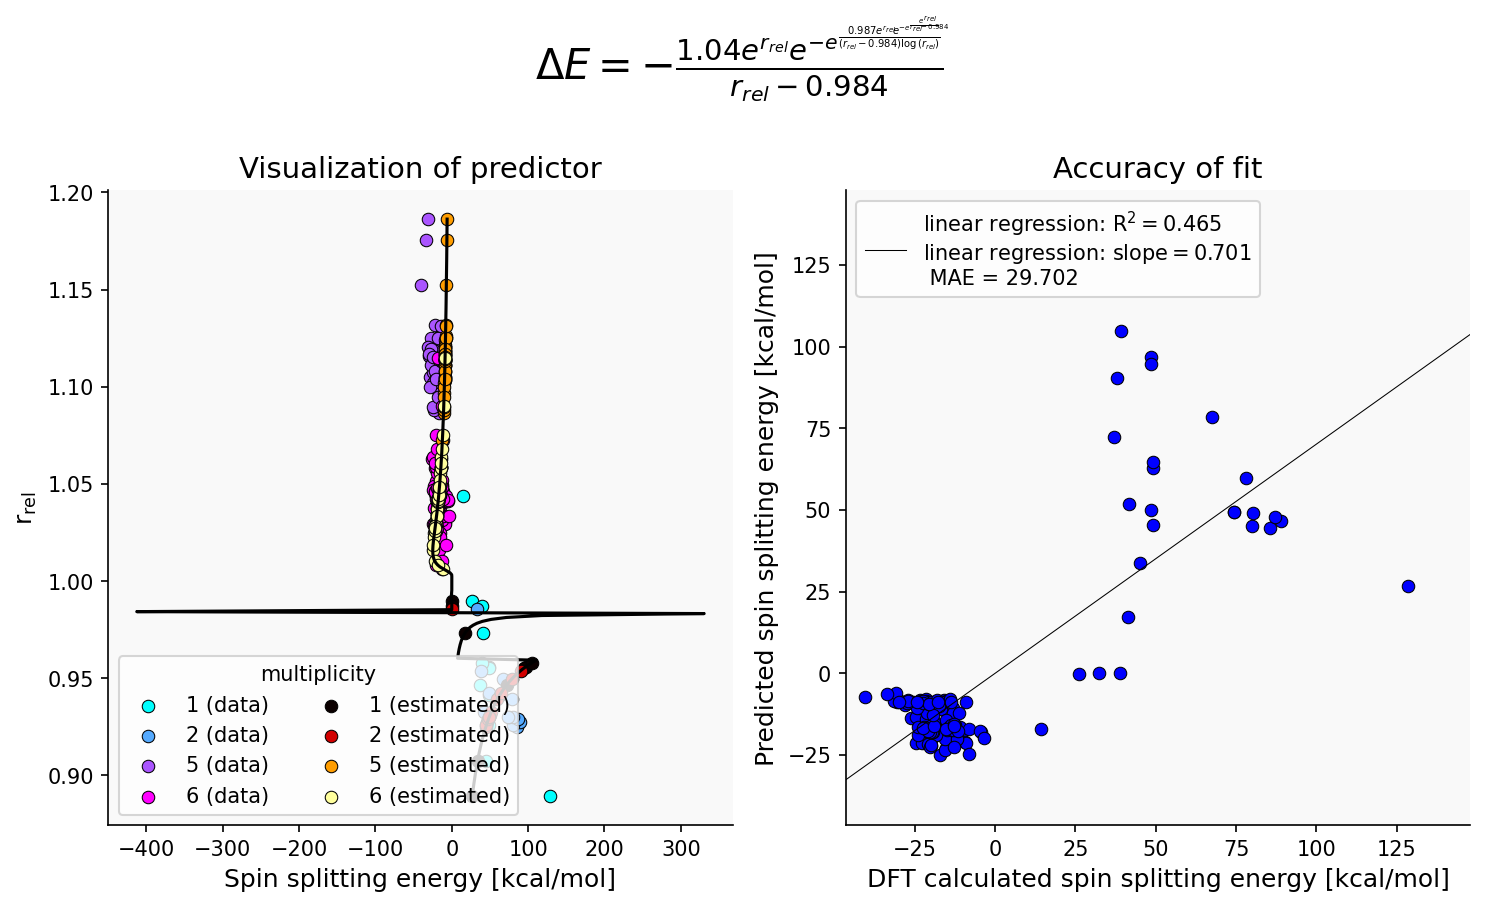

singularities in window: True
Spin estimation is 97.31543624161074
R squared is: 0.4650705246441279 and the slope is:0.7011596973733873
random state=3


KeyboardInterrupt: 

In [9]:
sys.setrecursionlimit(3000)

# Sets global coefficients for simple expressions and small calculation times based on trial and error done by hand.
population_size=300
generations=30
p_hoist_mutation=0.05
parsimony_coefficient=0.2
random_states=[2,3,5,7,11,13,42]

"""
Contains the indications on what runs are done to obtain the best parameters combinations during the grid search.
This will allow to explore some of the parameters combinations and give some plausibly good ones. However, not enough iterations have been done to explore sufficiently the space of configurations.
Also, taking the 10 best parameters out of a 100 parameters is a too big proportion to call them the best parameters. 
With the setup imposed from the grid defined, approximately 2500 combinations were possible so way too little space was covered.
"""

# The different types of parameters that were obtained are describe in the list below. This was defined as [function set used, metric used].
models_test = [[function_set_exp, 'mean absolute error'], [function_set_exp, custom_fitness_spike_cst_wrapped], [function_set_exp, custom_fitness_spike_cst_wrapped]]


# Holds the different combinations of parameters that could be explored.
param_grid = {
    'init_depth': [(2, 4), (2, 6), (4, 10)],
    'tournament_size':[5, 10, 15, 20],
    'p_crossover': [0.7, 0.8, 0.9],
    'p_subtree_mutation': [0.01, 0.025, 0.05, 0.075, 0.1],
    'p_point_mutation':[0.01, 0.025, 0.05, 0.075, 0.1],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}


# Can turn on and off the plotting of how welll the data perfomed. Turning off tis parameter makes the simulation faster and doesn't make the kernel die as quick.
# The expressions and the results for the training will still be printed if turned off.
display_plots = True

n_iter = 50  # Or however many combinations are wanted.
random_search = ParameterSampler(param_grid, n_iter=n_iter, random_state=42)


for model in models_test:

    # Holds the results for a certain set of parameters. It has the format [(average MAE over all the random seeds), (set of parameters)].
    results=[]

    # Goes through the different sets of parameters created before.
    for params in random_search:
        # Only continues if the set of paramaters has the condition set below. It is needed for the symbolic regressor creation.
        if params['p_crossover'] + params['p_subtree_mutation'] + p_hoist_mutation + params['p_point_mutation'] <= 1:
            print(f"Trying: {params}")
            
            # This list holds all the values of MAE for a certain set of parameter.
            scores = []

            # Loops over all the random seeds.
            for seed in random_states:
                print(f"random state={seed}")
                # The symbolic regressor is created with both the global parameters and the set of parameter looped over.
                est_gp = SymbolicRegressor(**params,
                                            function_set=model[0],
                                            population_size=population_size,
                                            generations=generations,
                                            p_hoist_mutation=p_hoist_mutation,
                                            parsimony_coefficient=parsimony_coefficient,
                                            metric=model[1],
                                            random_state=seed, 
                                            verbose=0)

                # The model is trained and the best estimator over the whole run is taken.
                est_gp.fit(X_train, y_train)
                best_program = find_best_program(est_gp)
                est_gp._program = best_program

                
                expr_str = sympify(est_gp._program.__str__(), locals = converter)
            
                y_pred = est_gp.predict(X_test_list_sorted.reshape(-1,1))
        
                # Find singularities in analytical expression according to the symbol X0.
                singularity_match = False
                found_singularities = singularities(expr_str, X0)
                

                # Finds if the final expression contains a singularity (or more) in the range observed in the training/testing of the model.
                if isinstance(found_singularities, FiniteSet):
                    for singularity in found_singularities:
                        # Don't consider imaginary values singularities.
                        if im(singularity) == 0:
                            val = float(singularity)
                            # Only considers it if it is in the range of training/testing of the model (between 0.834 and 1.20 approximately).
                            if val < max(Energies_total['rel_m']) and val > min(Energies_total['rel_m']):
                                singularity_match = True

                if display_plots:
                    MAE, r_squared, slope = visualize_estimator(est_gp)
                    display(plt.gcf())         # Show current figure
                    plt.close()
                
                else:
                    display(expr_str)
                    MAE, r_squared, slope = get_MAE_r_squared_slope_of_est(est_gp)
            
                
                print(f"singularities in window: {singularity_match}")
                print(f"Spin estimation is {percentage_same_sign(y_test_sorted, y_pred)}")
                print(f"R squared is: {r_squared} and the slope is:{slope}")
        
                scores.append(mean_absolute_error(y_test_sorted, y_pred))

            # The MAE over the 7 random seeds is averaged and added to the results
            avg_score = np.mean(scores)
            results.append((avg_score, params))

            print(f"Params: {params} | Avg MAE over seeds: {avg_score:.4f}")
        
    
    
    # Sort by score (ascending = better)
    results_sorted = sorted(results, key=lambda x: x[0])
    
    # Get the top 5 sets of parameters
    top_5_params = results_sorted[:5]
    
    for i, (score, params) in enumerate(top_5_params, 1):
        print(f"{i}. Avg Score: {score:.4f}, Params: {params}")


##### Those are the sets of parameters obtained if the best model is obtained for each traininf. This was considered as a wrongful manipulation as taking the best raw_fitness might have incensitized to have functions with singularities
Add, MAE:
1. Avg Score: 18.0115, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.025, 'p_crossover': 0.8, 'max_samples': 1.0, 'init_depth': (4, 10)}
2. Avg Score: 19.0545, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.01, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.9, 'init_depth': (2, 6)}
3. Avg Score: 19.9418, Params: {'tournament_size': 5, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 1.0, 'init_depth': (2, 6)}
4. Avg Score: 20.0129, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.025, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 6)}
5. Avg Score: 20.6397, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 6)}


Exp, custom_spike_cst
1. Avg Score: 10.4196, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 6)}
2. Avg Score: 13.0905, Params: {'tournament_size': 5, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.075, 'p_crossover': 0.8, 'max_samples': 0.5, 'init_depth': (4, 10)}
3. Avg Score: 17.8385, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.05, 'p_point_mutation': 0.075, 'p_crossover': 0.8, 'max_samples': 0.9, 'init_depth': (2, 6)}
4. Avg Score: 18.2669, Params: {'tournament_size': 5, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.8, 'init_depth': (2, 6)}
5. Avg Score: 18.9605, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.1, 'p_crossover': 0.7, 'max_samples': 0.5, 'init_depth': (2, 6)}


Exp, custom_spike
1. Avg Score: 24.2244, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.025, 'p_crossover': 0.9, 'max_samples': 0.7, 'init_depth': (4, 10)}
2. Avg Score: 28.5890, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.025, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 6)}
3. Avg Score: 28.7008, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.075, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 4)}
4. Avg Score: 28.8573, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.01, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.9, 'init_depth': (2, 6)}
5. Avg Score: 30.9724, Params: {'tournament_size': 10, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.1, 'p_crossover': 0.7, 'max_samples': 1.0, 'init_depth': (2, 6)}


### It was realized that maybe choosing the best expression out of the training only considering the MAE would force the models to be more daring, i.e. have more discontinuities. The rest of the analysis was done only for the parameters above but the parameters obtained without considering the best model for each training are presented below nonetheless for further analysis if needed.

Add, MAE:
1. Avg Score: 18.8762, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.025, 'p_crossover': 0.8, 'max_samples': 1.0, 'init_depth': (4, 10)}
2. Avg Score: 19.9872, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.025, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 6)}
3. Avg Score: 22.2195, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.01, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.9, 'init_depth': (2, 6)}
4. Avg Score: 22.6274, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.075, 'p_crossover': 0.7, 'max_samples': 0.9, 'init_depth': (2, 4)}
5. Avg Score: 22.6968, Params: {'tournament_size': 10, 'p_subtree_mutation': 0.05, 'p_point_mutation': 0.075, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 4)}


Exp, custom_spike_cst
1. Avg Score: 12.9950, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 6)}
2. Avg Score: 16.3379, Params: {'tournament_size': 5, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.8, 'init_depth': (2, 6)}
3. Avg Score: 17.7819, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.05, 'p_point_mutation': 0.075, 'p_crossover': 0.8, 'max_samples': 0.9, 'init_depth': (2, 6)}
4. Avg Score: 17.7977, Params: {'tournament_size': 5, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.075, 'p_crossover': 0.8, 'max_samples': 0.5, 'init_depth': (4, 10)}
5. Avg Score: 19.1709, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.025, 'p_crossover': 0.9, 'max_samples': 0.7, 'init_depth': (4, 10)}


Exp, custom_spike
1. Avg Score: 26.3313, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.025, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 6)}
2. Avg Score: 26.4979, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.025, 'p_crossover': 0.7, 'max_samples': 0.7, 'init_depth': (2, 6)}
3. Avg Score: 26.8797, Params: {'tournament_size': 15, 'p_subtree_mutation': 0.01, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.9, 'init_depth': (2, 6)}
4. Avg Score: 27.3621, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.05, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 6)}
5. Avg Score: 28.5099, Params: {'tournament_size': 20, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.075, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 4)}


In [ ]:
# This dictionary will hold all the coefficient of interest to rank the models on a basis of non-singularity behavior, spin agreement, r_squared and simplicity of expression.
dict_exp_spike_cst = {'I':[], 'II':[], 'III':[], 'IV':[], 'V':[], 'VI':[]}


In [11]:
# Redefines the fitness functions used for printing purposes in the .txt file as the custom_fitness_spike_wrapped has been proved to not be good.
fitness_functions_dict = {'mean absolute error':'mean absolute error',
                        "custom fitness function to penalize functions with big spikes and constant functions":custom_fitness_spike_cst_wrapped
                         }

function_set=['add', 'sub', 'mul', 'div']
custom_fitness_wrapped = mean absolute error
Calculating for the set of parameter {'tournament_size': 15, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 6)}
random state=2


X0**2/(1 - X0**2) + X0*(-30.8461538461538*X0**2 - 30.8461538461538*X0 + 24.8928461538462) - 10.0806451612903/(0.807 - X0)

add(div(X0, div(div(-0.026, -0.802), sub(sub(0.807, X0), mul(X0, X0)))), sub(div(mul(X0, X0), sub(div(X0, X0), mul(X0, X0))), div(div(-0.625, -0.062), sub(0.807, X0))))


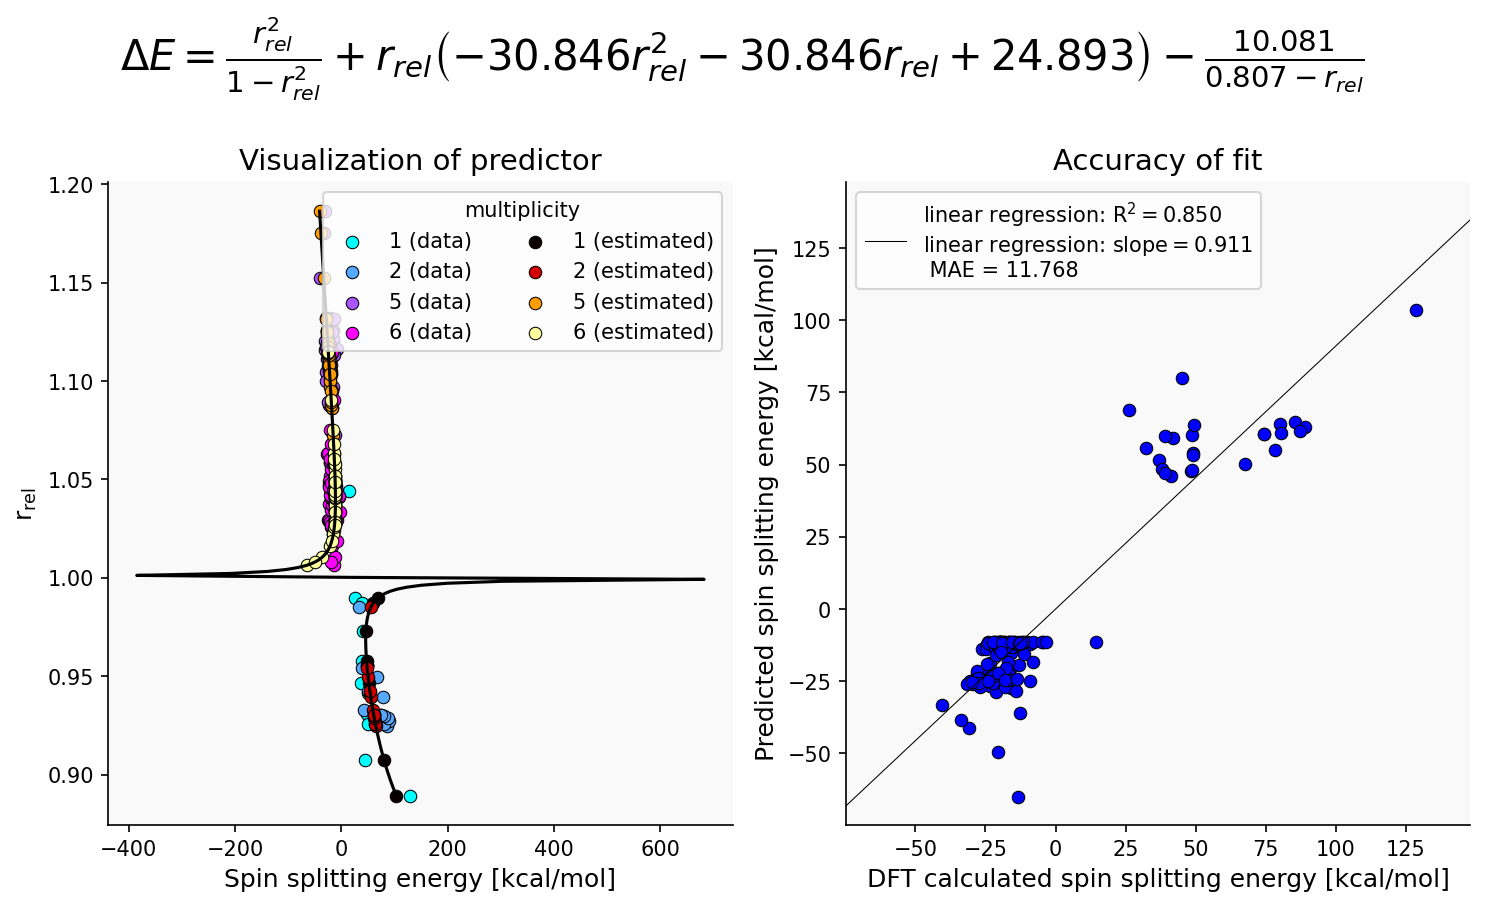

singularities in window: True
Spin estimation is 99.32885906040268
8.1517327458312
0.850428504502206 0.9111591391886764
0.8676530735773079
random state=3


KeyboardInterrupt: 

In [13]:
# The list of best parameters is defined.
Exp_spike_cst_params = [{'tournament_size': 15, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 6)},
                        {'tournament_size': 5, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.075, 'p_crossover': 0.8, 'max_samples': 0.5, 'init_depth': (4, 10)},
                        {'tournament_size': 20, 'p_subtree_mutation': 0.05, 'p_point_mutation': 0.075, 'p_crossover': 0.8, 'max_samples': 0.9, 'init_depth': (2, 6)},
                        {'tournament_size': 5, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.8, 'init_depth': (2, 6)},
                        {'tournament_size': 20, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.1, 'p_crossover': 0.7, 'max_samples': 0.5, 'init_depth': (2, 6)}
                        ]

# Global parameters are defined.
population_size=500                
generations=50
p_hoist_mutation=0.05
verbose=0
parsimony_coefficient=0.2
random_states=[2, 3, 5, 7, 11, 13, 42]

# Can turn on and off the plotting of how welll the data perfomed. Turning off tis parameter makes the simulation faster and doesn't make the kernel die as quick.
# The expressions and the results for the training will still be printed if turned off.
display_plots = True

# Overall the same steps are done than for the parameters estimation, but here it loops over all the sets of functions, for all the metrics, for all the parameters and then for all the random seeds. 
# It thus makes every combinations of function sets and metrics instead of the three types of models defined previously.
for idx_function_set, function_set in enumerate(function_sets):
    print(f"function_set={function_set}")
    
    for idx_custom_fitness_wrapped, custom_fitness_wrapped in enumerate(list(fitness_functions_dict.keys())):
        print(f"custom_fitness_wrapped = {custom_fitness_wrapped}")
        
        for params in Exp_spike_cst_params:
            print(f"Calculating for the set of parameter {params}")
            
            for random_state in random_states:
                print(f"random state={random_state}")
                est_gp = SymbolicRegressor(**params,
                    population_size=population_size,
                    generations=generations,
                    function_set=function_set,
                    p_hoist_mutation=p_hoist_mutation,
                    verbose=verbose,
                    parsimony_coefficient=parsimony_coefficient,
                    metric=fitness_functions_dict[custom_fitness_wrapped],
                    random_state=random_state) #Use Symbolic Regressor to start modeling
                
                est_gp.fit(X_train, y_train)
                best_program = find_best_program(est_gp) # Looks for the best estimator over the whole run
                est_gp._program = best_program

                expr_str = sympify(est_gp._program.__str__(), locals = converter)

                y_pred = est_gp.predict(X_test_list_sorted.reshape(-1,1))
    
                # Find singularities in analytical expression and if it is inside the window of training/testing, it is noted that the result is actually not correct.
                found_singularities = singularities(expr_str, X0)
                singularity_match = False
    
                if isinstance(found_singularities, FiniteSet):
                    for singularity in found_singularities:
                        # Don't consider imaginary values 
                        if im(singularity) == 0:
                            val = float(singularity)
                            if val < max(Energies_total['rel_m']) and val > min(Energies_total['rel_m']):
                                singularity_match = True
                
                if display_plots:
                    MAE, r_squared, slope = visualize_estimator(est_gp)
                    display(plt.gcf())         # Show current figure
                    plt.close()
                
                else:
                    display(expr_str)
                    MAE, r_squared, slope = get_MAE_r_squared_slope_of_est(est_gp)
                
                
            
                # 2*idx_function_set+idx_custom_fitness_wrapped brings to the correct key and so it appends the list to the corresponding place.
                # This dictionary can then be truned into a text file to store all the data for the models.
                dict_exp_spike_cst[list(dict_exp_spike_cst.keys())[2*idx_function_set+idx_custom_fitness_wrapped]].append([singularity_match, r_squared, percentage_same_sign(y_test_sorted, y_pred)
                                                                                                                  , MAE, slope, expr_str])
                print(f"singularities in window: {singularity_match}")
                print(f"Spin estimation is {percentage_same_sign(y_test_sorted, y_pred)}")
                print(mean_absolute_error(y_test_sorted, y_pred))
                print(r_squared, slope)
                print(est_gp.score(X_test, y_test))


In [11]:
# This dictionary will hold all the coefficient of interest to rank the models on a basis of non-singularity behavior, spin agreement, r_squared and simplicity of expression.
df_add_MAE = {'I':[], 'II':[], 'III':[], 'IV':[], 'V':[], 'VI':[]}

function_set=['add', 'sub', 'mul', 'div']
custom_fitness_wrapped = mean absolute error
Calculating for the set of parameter {'tournament_size': 15, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.025, 'p_crossover': 0.8, 'max_samples': 1.0, 'init_depth': (4, 10)}
random state=2


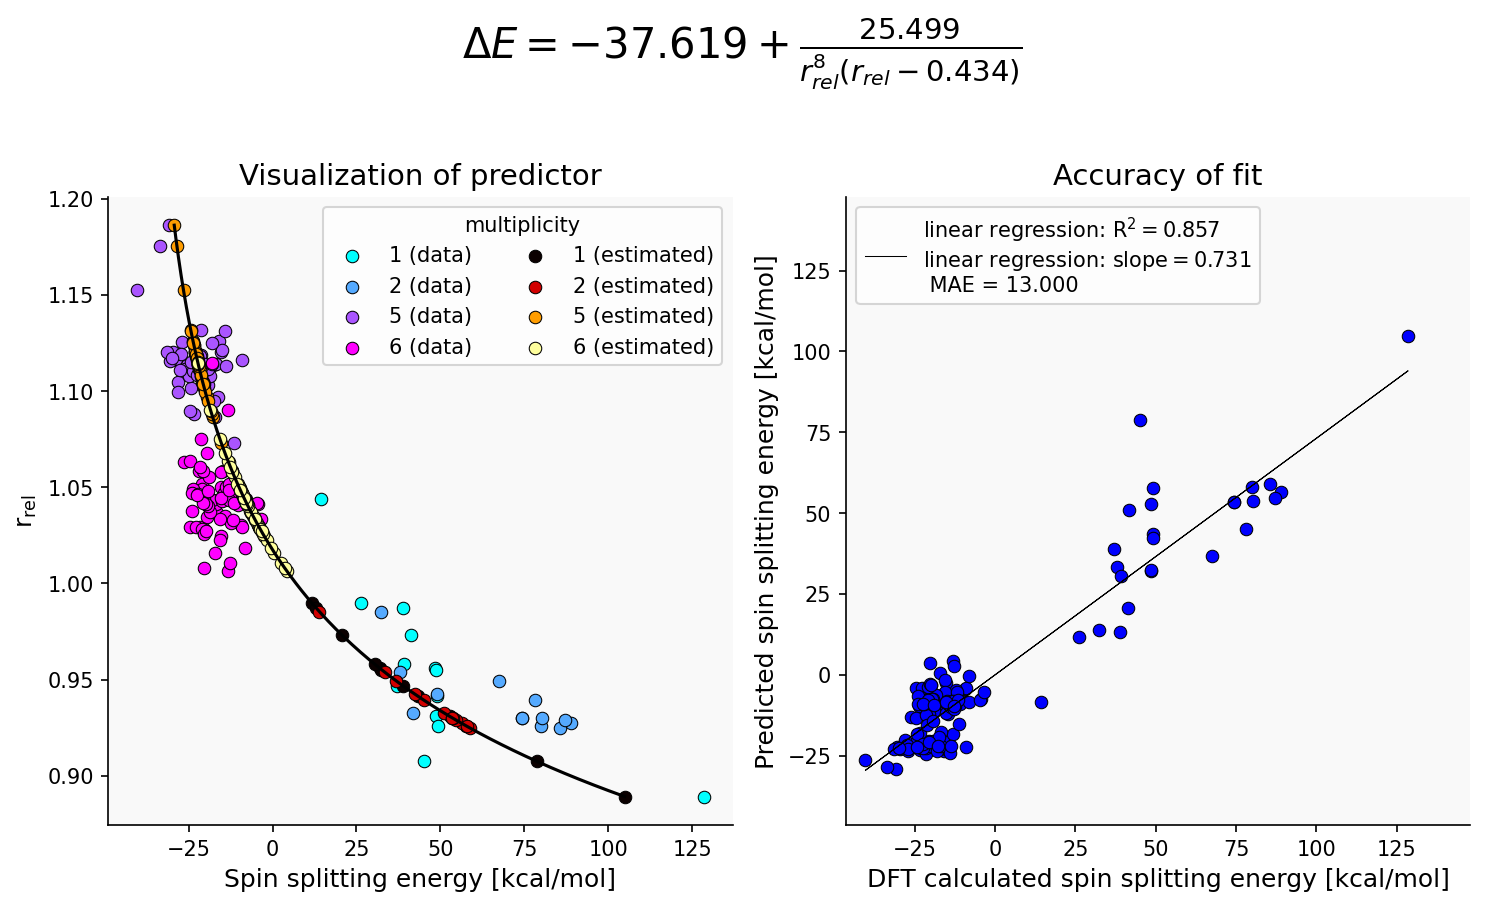

singularities in window: False
Spin estimation is 96.64429530201342
9.486569807059347
R squared is 0.8572191152178074 and slope is 0.7310402980669519
random state=3


KeyboardInterrupt: 

In [14]:
Add_MAE_params = [{'tournament_size': 15, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.025, 'p_crossover': 0.8, 'max_samples': 1.0, 'init_depth': (4, 10)},
                  {'tournament_size': 15, 'p_subtree_mutation': 0.01, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.9, 'init_depth': (2, 6)},
                  {'tournament_size': 5, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 1.0, 'init_depth': (2, 6)},
                  {'tournament_size': 15, 'p_subtree_mutation': 0.075, 'p_point_mutation': 0.025, 'p_crossover': 0.7, 'max_samples': 0.8, 'init_depth': (2, 6)},
                  {'tournament_size': 15, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 6)}
                  ]


population_size=500                 
generations=50
p_hoist_mutation=0.05
verbose=0
parsimony_coefficient=0.2
random_states=[2, 3, 5, 7, 11, 13, 42]

display_plots = True

for idx_function_set, function_set in enumerate(function_sets):
    print(f"function_set={function_set}")
    
    for idx_custom_fitness_wrapped, custom_fitness_wrapped in enumerate(list(fitness_functions_dict.keys())):
        print(f"custom_fitness_wrapped = {custom_fitness_wrapped}")
        
        for params in Add_MAE_params:
            print(f"Calculating for the set of parameter {params}")

            for random_state in random_states:

                print(f"random state={random_state}")

                
                est_gp = SymbolicRegressor(**params,
                    population_size=population_size,
                    generations=generations,
                    function_set=function_set,
                    p_hoist_mutation=p_hoist_mutation,
                    verbose=verbose,
                    parsimony_coefficient=parsimony_coefficient,
                    metric=fitness_functions_dict[custom_fitness_wrapped],
                    random_state=random_state) #Use Symbolic Regressor to start modeling
                
                est_gp.fit(X_train, y_train)
                best_program = find_best_program(est_gp) # Looks for the best estimator over the whole run
                est_gp._program = best_program
                
                expr_str = sympify(est_gp._program.__str__(), locals = converter)
                display(expr_str)
                print(est_gp._program)
                y_pred = est_gp.predict(X_test_list_sorted.reshape(-1,1))
    
                # Find singularities in analytical expression and if it is inside the window of training/testing, it is noted that the result is actually not correct.
                found_singularities = singularities(expr_str, X0)
                singularity_match = False
    
                if isinstance(found_singularities, FiniteSet):
                    for singularity in found_singularities:
                        # Don't consider imaginary values 
                        if im(singularity) == 0:
                            val = float(singularity)
                            if val < max(Energies_total['rel_m']) and val > min(Energies_total['rel_m']):
                                singularity_match = True

                                
                if display_plots:
                    MAE, r_squared, slope = visualize_estimator(est_gp)
                    display(plt.gcf())         # Show current figure
                    plt.close()
                
                else:
                    display(expr_str)
                    MAE, r_squared, slope = get_MAE_r_squared_slope_of_est(est_gp)
                    
            
                df_add_MAE[list(df_add_MAE.keys())[2*idx_function_set+idx_custom_fitness_wrapped]].append([singularity_match, r_squared, percentage_same_sign(y_test_sorted, y_pred),MAE, slope, expr_str
                                                                                                          ])
                print(f"singularities in window: {singularity_match}")
                print(f"Spin estimation is {percentage_same_sign(y_test_sorted, y_pred)}")
                print(mean_absolute_error(y_test_sorted, y_pred))
                print(f"R squared is {r_squared} and slope is {slope}")
    

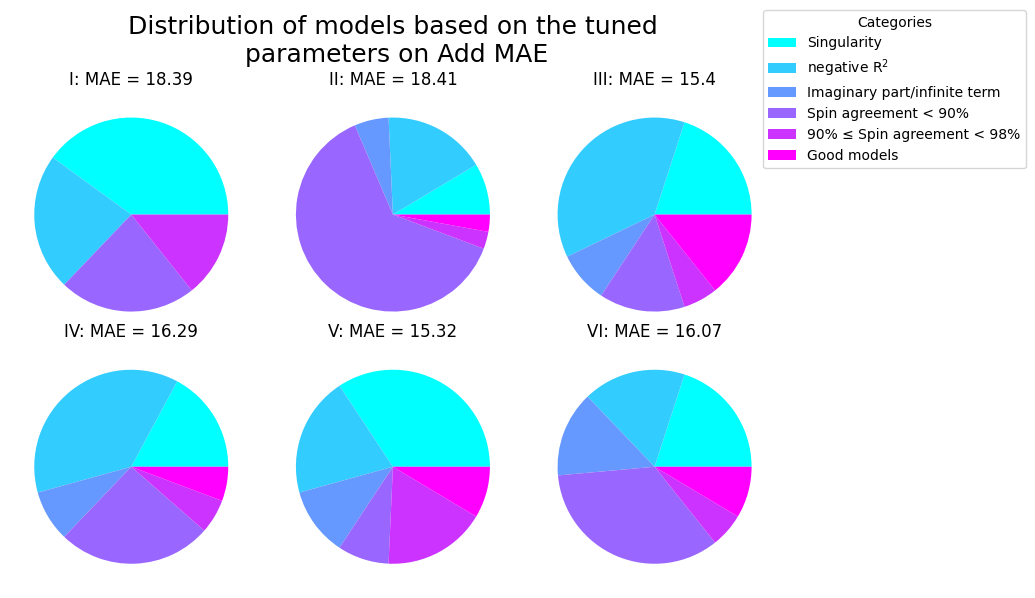

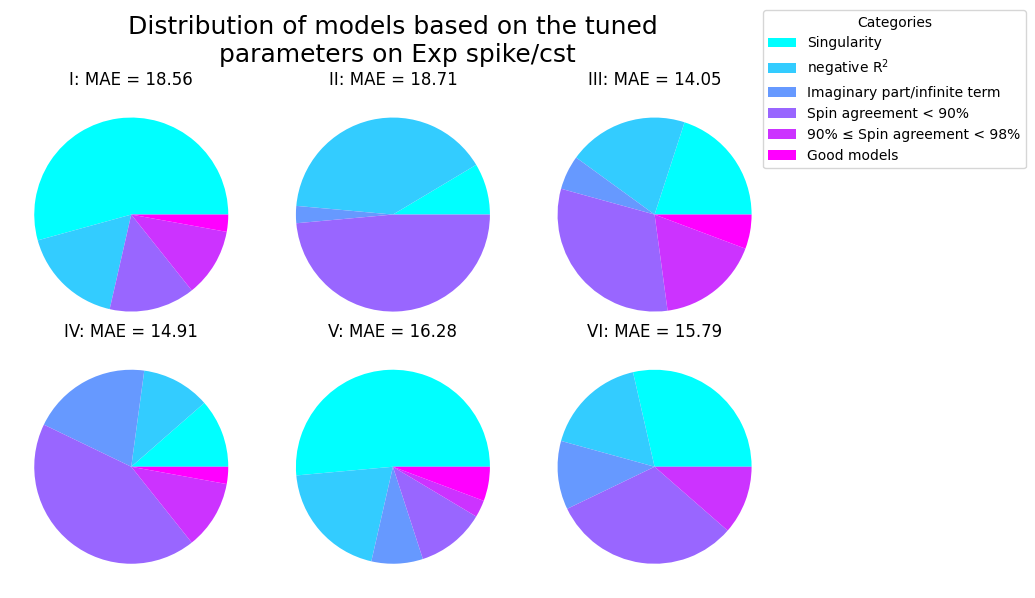

In [9]:
good_models_add = visualize_models(df_add, 'Add')
good_models_exp = visualize_models(df_exp, 'Exp')

In [10]:
for expr_tot in good_models_add:
    expr = expr_tot[2]
    if not expr[5].has(I) and not expr[5].has(zoo):
        if expr[4] > 0.9:
            display(expr[5])

            print(expr_tot[0], expr_tot[1])
            print(f"singularities in window: {expr[0]}")
            print(f"Spin estimation is {expr[2]}")
            print(expr[5])
            print(f"MAE = {expr[3]}, r squared = {expr[1]} slope = {expr[4]}")

((-X0**27 + X0)**0.333333333333333 + 0.287496)/(X0 - 0.66)**3

III 9
singularities in window: False
Spin estimation is 99.32885906040268
((-X0**27 + X0)**0.333333333333333 + 0.287496)/(X0 - 0.66)**3
MAE = 9.6085792434571, r squared = 0.9150371715068174 slope = 0.9086522655512669


exp((-log(X0) + 1.06822671716599 + 0.238/X0)/(0.363832849149905*X0**2 + 0.0240129680438938)) - 1.01106072244472 + 2.74851488076598/(log(X0) - 0.238/X0) - 0.755555555555556/(X0*log(X0))

V 31
singularities in window: False
Spin estimation is 99.32885906040268
exp((-log(X0) + 1.06822671716599 + 0.238/X0)/(0.363832849149905*X0**2 + 0.0240129680438938)) - 1.01106072244472 + 2.74851488076598/(log(X0) - 0.238/X0) - 0.755555555555556/(X0*log(X0))
MAE = 10.085024521294521, r squared = 0.7262652042973462 slope = 0.9775720165964455


144.780824995888*log(X0)*log(log(X0))*log(log(log(X0)))*log(log(log(exp(-0.825157024793388/X0)))) - log(4.9e-5*X0**2)

VI 24
singularities in window: False
Spin estimation is 99.32885906040268
144.780824995888*log(X0)*log(log(X0))*log(log(log(X0)))*log(log(log(exp(-0.825157024793388/X0)))) - log(4.9e-5*X0**2)
MAE = 11.442899168644729, r squared = 0.8851597890261439 slope = 0.9662545291311431


In [11]:
for expr_tot in good_models_exp:
    expr = expr_tot[2]
    if not expr[5].has(I) and not expr[5].has(zoo):
        if expr[4] > 0.9:
            display(expr[5])

            print(expr_tot[0], expr_tot[1])
            print(f"singularities in window: {expr[0]}")
            print(f"Spin estimation is {expr[2]}")
            print(expr[5])
            print(f"MAE = {expr[3]}, r squared = {expr[1]} slope = {expr[4]}")
    




(21.9098976359467 - 15.618786194263*(1.982*(X0 + 0.219)**0.333333333333333 - 0.235482403072)/X0)*(X0**(-2.66666666666667) + 0.588304818831185)**3*(X0**9 + 0.641530054644809 - (X0 + 0.781648)/X0**9)**0.333333333333333

III 23
singularities in window: False
Spin estimation is 99.32885906040268
(21.9098976359467 - 15.618786194263*(1.982*(X0 + 0.219)**0.333333333333333 - 0.235482403072)/X0)*(X0**(-2.66666666666667) + 0.588304818831185)**3*(X0**9 + 0.641530054644809 - (X0 + 0.781648)/X0**9)**0.333333333333333
MAE = 11.291001550997747, r squared = 0.8992950606947384 slope = 0.9313716285538325


2.38222814356827*((0.462306462179691*X0**0.333333333333333 + ((0.609 - X0)/X0**7)**0.111111111111111)**3)**0.111111111111111/(X0 - 0.609)**3

III 30
singularities in window: False
Spin estimation is 99.32885906040268
2.38222814356827*((0.462306462179691*X0**0.333333333333333 + ((0.609 - X0)/X0**7)**0.111111111111111)**3)**0.111111111111111/(X0 - 0.609)**3
MAE = 8.898563779040613, r squared = 0.8539072303073924 slope = 0.9420798629777917


exp((-log(X0) + 1.06822671716599 + 0.238/X0)/(0.363832849149905*X0**2 + 0.0240129680438938)) - 1.01106072244472 + 2.74851488076598/(log(X0) - 0.238/X0) - 0.755555555555556/(X0*log(X0))

V 3
singularities in window: False
Spin estimation is 99.32885906040268
exp((-log(X0) + 1.06822671716599 + 0.238/X0)/(0.363832849149905*X0**2 + 0.0240129680438938)) - 1.01106072244472 + 2.74851488076598/(log(X0) - 0.238/X0) - 0.755555555555556/(X0*log(X0))
MAE = 10.085024521294521, r squared = 0.7262652042973462 slope = 0.9775720165964455


In [13]:
"""
This should be able to retranscribe the stored expressions into a numpy function object and visualize the expression but the scalar power runtime error doesn't allow to visualize every point. As a result, NaNs are obtained and mess up the visualization.
from sympy import lambdify
estimator_test_add = lambdify([X0], good_models_add[4][2][5])
y_pred_test_add = [estimator_test_add(X_test_list_sorted[i]) for i in range(len(X_test_list_sorted))]
visualize_estimator(estimator_test_add)
"""

"\nThis should be able to retranscribe the stored expressions into a numpy function object and visualize the expression but the scalar power runtime error doesn't allow to visualize every point. As a result, NaNs are obtained and mess up the visualization.\nfrom sympy import lambdify\nestimator_test_add = lambdify([X0], good_models_add[4][2][5])\ny_pred_test_add = [estimator_test_add(X_test_list_sorted[i]) for i in range(len(X_test_list_sorted))]\nvisualize_estimator(estimator_test_add)\n"

# The best model obtained is presented below.

(np.float64(9.6085792434571),
 np.float64(0.9150371715068174),
 np.float64(0.9086522655512669))

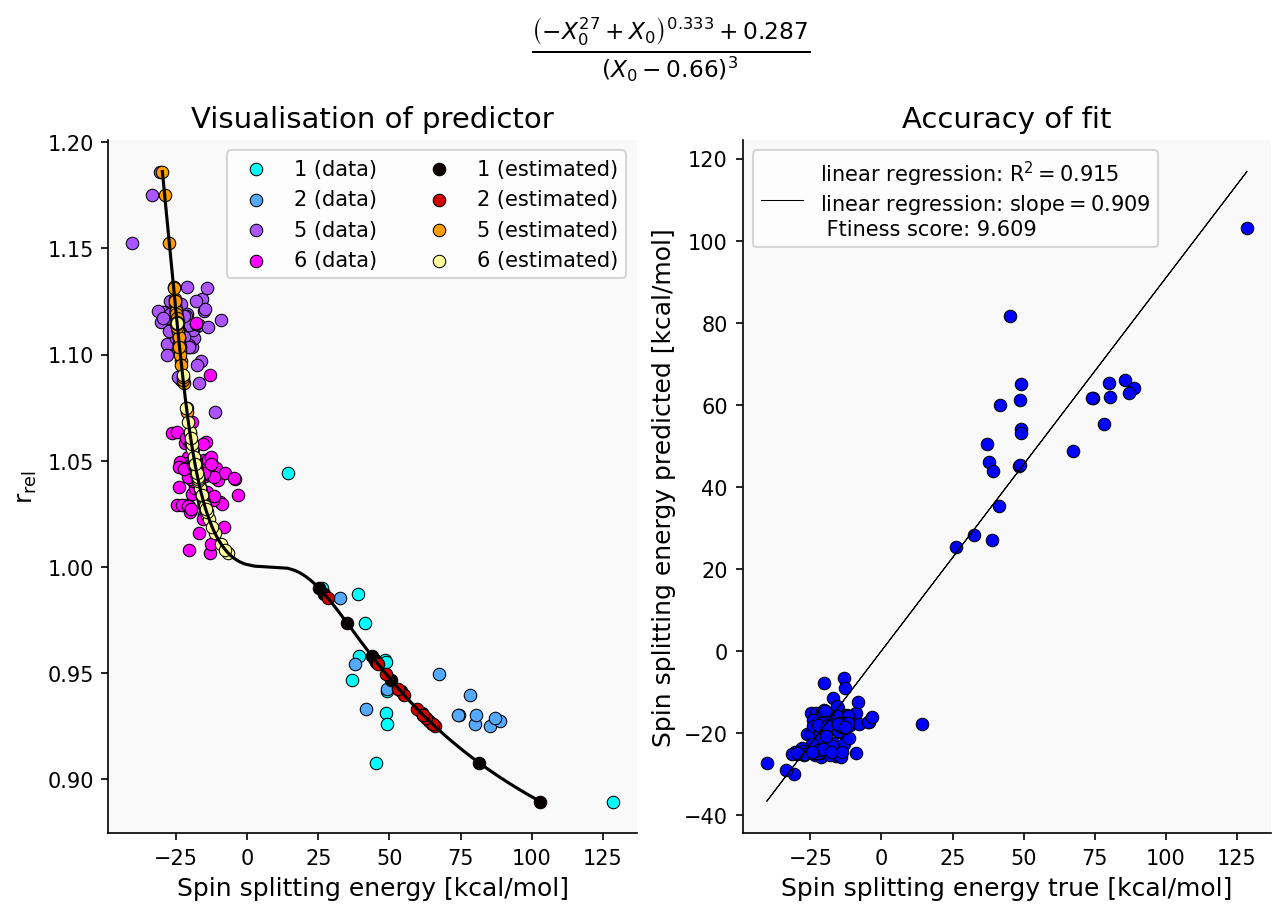

In [48]:
visualize_estimator(est_gp)

### The best results obtained for the Exp spike/cst model with the following parameters.
{'tournament_size': 5, 'p_subtree_mutation': 0.025, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.8, 'init_depth': (2, 6)}
function_set=Pow3
custom_fitness_wrapped = mean absolute error
random state=5


{'tournament_size': 20, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.1, 'p_crossover': 0.7, 'max_samples': 0.5, 'init_depth': (2, 6)}
function_set=Pow3
custom_fitness_wrapped = mean absolute error
random state=3


{'tournament_size': 15, 'p_subtree_mutation': 0.1, 'p_point_mutation': 0.05, 'p_crossover': 0.8, 'max_samples': 0.7, 'init_depth': (2, 6)}
function_set=Exp
custom_fitness_wrapped = mean absolute error
random state=7

### And for the Add MAE models
{'tournament_size': 15, 'p_subtree_mutation': 0.01, 'p_point_mutation': 0.01, 'p_crossover': 0.9, 'max_samples': 0.9, 'init_depth': (2, 6)}, function_set=Pow3, custom_fitness_wrapped = mean absolute error random state=5